# Valuing European and American options

I have written about option pricing earlier. The [introduction to option pricing](http://gouthamanbalaraman.com/blog/option-model-handbook-part-I-introduction-to-option-models.html) gave an overview of the theory behind option pricing. The post on [introduction to binomial trees](http://gouthamanbalaraman.com/blog/option-model-handbook-part-II-introduction-to-binomial-trees.html) outlined the binomial tree method to price options.

In this post, we will use QuantLib and the Python extension to illustrate a simple example. Here we are going to price a European option using the Black-Scholes-Merton formula. We will price them again using the Binomial tree and understand the agreement between the two. 

In [1]:
from QuantLib import *
import utils
%matplotlib inline

#### European Option

Let us consider a European call option for AAPL with a strike price of 130 maturing on 15th Jan, 2016. Let the spot price be 127.62. The volatility of the underlying stock is know to be 20%, and has a dividend yield of 1.63%. Let's value this option as of 8th May, 2015.

In [2]:
maturity_date = Date(15, 1, 2016)
spot_price = 127.62
strike_price = 130
volatility = 0.20 # the historical vols for a year
dividend_rate =  0.0163
option_type = Option.Call

risk_free_rate = 0.001
day_count = Actual365Fixed()
calendar = UnitedStates()

calculation_date = Date(8, 5, 2015)
Settings.instance().evaluationDate = calculation_date

We construct the European option here.

In [3]:
payoff = PlainVanillaPayoff(option_type, strike_price)
exercise = EuropeanExercise(maturity_date)
european_option = VanillaOption(payoff, exercise)

The Black-Scholes-Merton process is constructed here.

In [4]:
spot_handle = QuoteHandle(
    SimpleQuote(spot_price)
)
flat_ts = YieldTermStructureHandle(
    FlatForward(calculation_date, 
                risk_free_rate, 
                day_count)
)
dividend_yield = YieldTermStructureHandle(
    FlatForward(calculation_date, 
                dividend_rate, 
                day_count)
)
flat_vol_ts = BlackVolTermStructureHandle(
    BlackConstantVol(calculation_date, 
                     calendar, 
                     volatility, 
                     day_count)
)
bsm_process = BlackScholesMertonProcess(spot_handle, 
                                        dividend_yield, 
                                        flat_ts, 
                                        flat_vol_ts)

Lets compute the theoretical price using the `AnalyticEuropeanEngine`.

In [5]:
european_option.setPricingEngine(AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print("The theoretical price is %lf" % bs_price)

The theoretical price is 6.749272


Lets compute the price using the binomial-tree approach.

In [6]:
def binomial_price(option, bsm_process, steps):
    binomial_engine = BinomialVanillaEngine(bsm_process, "crr", steps)
    option.setPricingEngine(binomial_engine)
    return option.NPV()

steps = range(2, 200, 1)
prices = [binomial_price(european_option, bsm_process, step) for step in steps]

In the plot below, we show the convergence of binomial-tree approach by comparing its price with the BSM price.

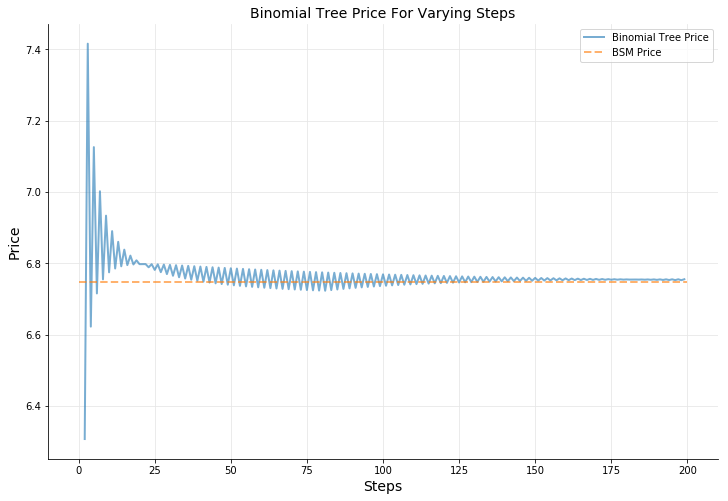

In [7]:
fig, ax = utils.plot()
ax.plot(steps, prices, label="Binomial Tree Price", lw=2, alpha=0.6)
ax.plot([0,200],[bs_price, bs_price], "--", label="BSM Price", lw=2, alpha=0.6)
ax.set_xlabel("Steps", size=14)
ax.set_ylabel("Price", size=14)
ax.set_title("Binomial Tree Price For Varying Steps", size=14)
ax.legend();

#### American Option

The above exercise was pedagogical, and introduces one to pricing using the binomial tree approach and compared with Black-Scholes. As a next step, we will use the Binomial pricing to value American options.

The construction of an American option is similar to the construction of `European` option discussed above. The one main difference is the use of `AmericanExercise` instead of `EuropeanExercise` use above. 

In [8]:
payoff = PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date
am_exercise = AmericanExercise(settlement, maturity_date)
american_option = VanillaOption(payoff, am_exercise)

Once we have constructed the `american_option` object, we can price them using the Binomial trees as done above. We use the same function we constructed above.

In [9]:
steps = range(2, 200, 1)
prices = [binomial_price(american_option, bsm_process, step) for step in steps]

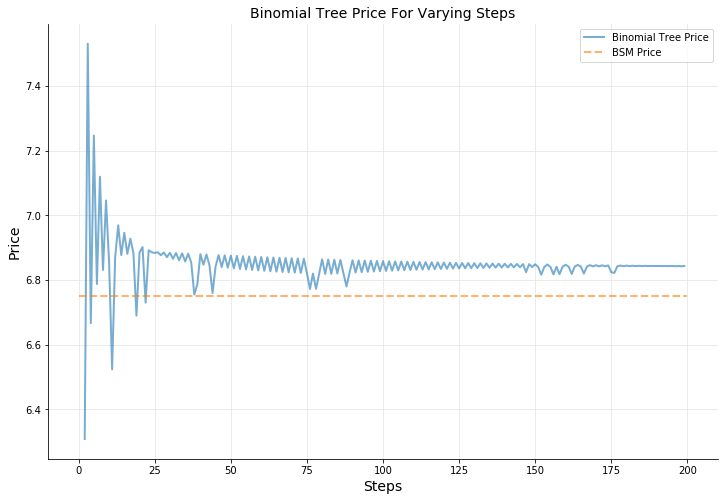

In [10]:
fig, ax = utils.plot()
ax.plot(steps, prices, label="Binomial Tree Price", lw=2, alpha=0.6)
ax.plot([0,200],[bs_price, bs_price], "--", label="BSM Price", lw=2, alpha=0.6)
ax.set_xlabel("Steps", size=14)
ax.set_ylabel("Price", size=14)
ax.set_title("Binomial Tree Price For Varying Steps", size=14)
ax.legend();

Above, we plot the price of the American option as a function of steps used in the binomial tree, and compare with that of the Black-Scholes price for the European option with all other variables remaining the same. The binomial tree converges as the number of steps used in pricing increases. American option is valued more than the European BSM price because of the fact that it can be exercised anytime during the course of the option.

#### Conclusion

In this chapter we learnt about valuing European and American options using the binomial tree method. 